You can read an overview of this Numerical Linear Algebra course in [this blog post](http://www.fast.ai/2017/07/17/num-lin-alg/).  The course was originally taught in the [University of San Francisco MS in Analytics](https://www.usfca.edu/arts-sciences/graduate-programs/analytics) graduate program.  Course lecture videos are [available on YouTube](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) (note that the notebook numbers and video numbers do not line up, since some notebooks took longer than 1 video to cover).

You can ask questions about the course on [our fast.ai forums](http://forums.fast.ai/c/lin-alg).

# 7. How to Implement Linear Regression

In the previous lesson, we calculated the least squares linear regression for a diabetes dataset, using scikit learn's implementation.  Today, we will look at how we could write our own implementation.

In [1]:
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math, scipy, numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=6)

In [3]:
data = datasets.load_diabetes()

In [4]:
data.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [5]:
feature_names=['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [6]:
trn,test,y_trn,y_test = train_test_split(data.data, data.target, test_size=0.2)

In [7]:
trn.shape, test.shape

((353, 10), (89, 10))

In [8]:
def regr_metrics(act, pred):
    return (math.sqrt(metrics.mean_squared_error(act, pred)), 
     metrics.mean_absolute_error(act, pred))

### How did sklearn do it?

How is sklearn doing this?  By checking [the source code](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/linear_model/base.py#L417), you can see that in the dense case, it calls [scipy.linalg.lstqr](https://github.com/scipy/scipy/blob/v0.19.0/scipy/linalg/basic.py#L892-L1058), which is calling a LAPACK method:

        Options are ``'gelsd'``, ``'gelsy'``, ``'gelss'``. Default
        (``'gelsd'``) is a good choice.  However, ``'gelsy'`` can be slightly
        faster on many problems.  ``'gelss'`` was used historically.  It is
        generally slow but uses less memory.

- [gelsd](https://software.intel.com/sites/products/documentation/doclib/mkl_sa/11/mkl_lapack_examples/_gelsd.htm): uses SVD and a divide-and-conquer method
- [gelsy](https://software.intel.com/en-us/node/521113): uses QR factorization
- [gelss](https://software.intel.com/en-us/node/521114): uses SVD

#### Scipy Sparse Least Squares

We will not get into too much detail about the sparse version of least squares.  Here is a bit of info if you are interested: 

[Scipy sparse lsqr](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html#id1) uses an iterative method called [Golub and Kahan bidiagonalization](https://web.stanford.edu/class/cme324/paige-saunders2.pdf).

from [scipy sparse lsqr source code](https://github.com/scipy/scipy/blob/v0.14.0/scipy/sparse/linalg/isolve/lsqr.py#L96):
  Preconditioning is another way to reduce the number of iterations. If it is possible to solve a related system ``M*x = b`` efficiently, where M approximates A in some helpful way (e.g. M - A has low rank or its elements are small relative to those of A), LSQR may converge more rapidly on the system ``A*M(inverse)*z = b``, after which x can be recovered by solving M\*x = z.
  
If A is symmetric, LSQR should not be used! Alternatives are the symmetric conjugate-gradient method (cg) and/or SYMMLQ.  SYMMLQ is an implementation of symmetric cg that applies to any symmetric A and will converge more rapidly than LSQR.  If A is positive definite, there are other implementations of symmetric cg that require slightly less work per iteration than SYMMLQ (but will take the same number of iterations).

### linalg.lstqr

The sklearn implementation handled adding a constant term (since the y-intercept is presumably not 0 for the line we are learning) for us.  We will need to do that by hand now:

In [9]:
trn_int = np.c_[trn, np.ones(trn.shape[0])]
test_int = np.c_[test, np.ones(test.shape[0])]

Since `linalg.lstsq` lets us specify which LAPACK routine we want to use, lets try them all and do some timing comparisons:

In [10]:
import time
def timecost(f, *arg, **kwang):
    t1 = time.time()
    x = eval(f)(*arg, **kwang)
    t2 = time.time()
    print(t2-t1)
    return x

In [14]:
#%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsd")
x = timecost('linalg.lstsq',trn_int, y_trn, lapack_driver="gelsd")
x = timecost('linalg.lstsq',trn_int, y_trn, lapack_driver="gelsy")
x = timecost('linalg.lstsq',trn_int, y_trn, lapack_driver="gelss")

0.0007598400115966797
0.0003559589385986328
0.00024819374084472656


In [15]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsy")

40.7 µs ± 248 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelss")

54 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Naive Solution

Recall that we want to find $\hat{x}$ that minimizes: 
$$ \big\vert\big\vert Ax - b \big\vert\big\vert_2$$

Another way to think about this is that we are interested in where vector $b$ is closest to the subspace spanned by $A$ (called the *range of* $A$).  This is the projection of $b$ onto $A$.  Since $b - A\hat{x}$ must be perpendicular to the subspace spanned by $A$, we see that

$$A^T (b - A\hat{x}) = 0 $$

(we are using $A^T$ because we want to multiply each column of $A$ by $b - A\hat{x}$

This leads us to the *normal equations*:
$$ x = (A^TA)^{-1}A^T b $$

In [17]:
def ls_naive(A, b):
     return np.linalg.inv(A.T @ A) @ A.T @ b

In [18]:
%timeit coeffs_naive = ls_naive(trn_int, y_trn)

52.2 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


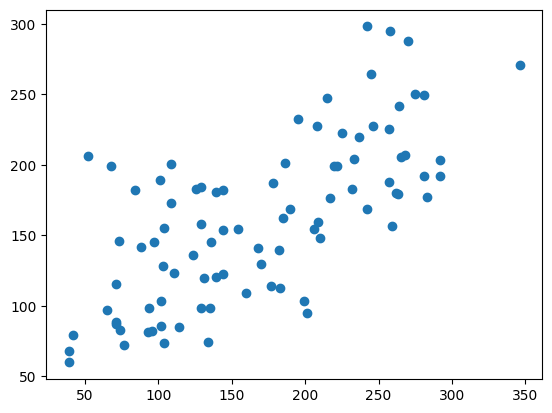

In [19]:
coeffs_naive = ls_naive(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_naive)
plt.scatter(y_test, test_int @ coeffs_naive)

### Normal Equations (Cholesky)

Normal equations:
$$ A^TA x = A^T b $$

If $A$ has full rank, the pseudo-inverse $(A^TA)^{-1}A^T$ is a **square, hermitian positive definite** matrix.  The standard way of solving such a system is *Cholesky Factorization*, which finds upper-triangular R s.t. $A^TA = R^TR$.

The following steps are based on Algorithm 11.1 from Trefethen:

In [20]:
A = trn_int

In [21]:
b = y_trn

In [22]:
AtA = A.T @ A
Atb = A.T @ b

**Warning:** Numpy and Scipy default to different upper/lower for Cholesky

In [24]:
R = scipy.linalg.cholesky(AtA)

In [73]:
np.set_printoptions(suppress=True, precision=4)
R

array([[ 0.9041,  0.1783,  0.1718,  0.3004,  0.2438,  0.2181, -0.1089,
         0.2135,  0.2567,  0.2636, -0.1   ],
       [ 0.    ,  0.8753,  0.1017,  0.1894, -0.0357,  0.075 , -0.3393,
         0.2476,  0.0756,  0.1509, -0.1233],
       [ 0.    ,  0.    ,  0.8631,  0.2624,  0.1913,  0.2067, -0.2969,
         0.3262,  0.3584,  0.316 , -0.4745],
       [ 0.    ,  0.    ,  0.    ,  0.7573,  0.0641, -0.0043,  0.0032,
         0.0176,  0.1591,  0.1527,  0.0845],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.8419,  0.7626,  0.1275,
         0.3969,  0.3276,  0.1442,  0.1389],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.3557, -0.412 ,
         0.2804, -0.3028, -0.0131,  0.5824],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6218,
        -0.4933, -0.5284, -0.1694,  1.0473],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.2953, -0.0161,  0.0326, -0.0082],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
 

check our factorization:

In [26]:
np.linalg.norm(AtA - R.T @ R)

5.684476525667183e-14

$$ A^T A x = A^T b $$
$$ R^T R x = A^T b $$
$$ R^T w = A^T b $$
$$ R x = w $$

In [27]:
w = scipy.linalg.solve_triangular(R, Atb, lower=False, trans='T')

It's always good to check that our result is what we expect it to be: (in case we entered the wrong params, the function didn't return what we thought, or sometimes the docs are even outdated)

In [28]:
np.linalg.norm(R.T @ w - Atb)

7.278177721522856e-12

In [29]:
coeffs_chol = scipy.linalg.solve_triangular(R, w, lower=False)

In [30]:
np.linalg.norm(R @ coeffs_chol - w)

1.2131359795094364e-13

In [31]:
def ls_chol(A, b):
    R = scipy.linalg.cholesky(A.T @ A)
    w = scipy.linalg.solve_triangular(R, A.T @ b, trans='T')
    return scipy.linalg.solve_triangular(R, w)

In [32]:
%timeit coeffs_chol = ls_chol(trn_int, y_trn)

24.3 µs ± 198 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [33]:
coeffs_chol = ls_chol(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_chol)

(53.939622798655726, 43.67201387697411)

### QR Factorization

$$ A x = b $$
$$ A = Q R $$
$$ Q R x = b $$

$$ R x = Q^T b $$

In [34]:
def ls_qr(A,b):
    Q, R = scipy.linalg.qr(A, mode='economic')
    return scipy.linalg.solve_triangular(R, Q.T @ b)

In [35]:
%timeit coeffs_qr = ls_qr(trn_int, y_trn)

43.8 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [36]:
coeffs_qr = ls_qr(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_qr)

(53.93962279865572, 43.67201387697411)

### SVD

$$ A x = b $$

$$ A = U \Sigma V $$

$$ \Sigma V x = U^T b $$

$$ \Sigma w = U^T b $$

$$ x = V^T w $$

SVD gives the pseudo-inverse

In [37]:
def ls_svd(A,b):
    m, n = A.shape
    U, sigma, Vh = scipy.linalg.svd(A, full_matrices=False, lapack_driver='gesdd')
    w = (U.T @ b)/ sigma
    return Vh.T @ w

In [38]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

59.7 µs ± 234 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [39]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

59.7 µs ± 221 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
coeffs_svd = ls_svd(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_svd)

(53.93962279865573, 43.67201387697413)

### Random Sketching Technique for Least Squares Regression

[Linear Sketching](http://researcher.watson.ibm.com/researcher/files/us-dpwoodru/journal.pdf) (Woodruff)

1. Sample a r x n random matrix S, r << n
2. Compute S A and S b
3. Find exact solution x to regression SA x = Sb

### Timing Comparison

In [41]:
import timeit
import pandas as pd

In [57]:
def scipylstq(A, b):
    return scipy.linalg.lstsq(A,b)[0]

In [43]:
row_names = ['Normal Eqns- Naive',
             'Normal Eqns- Cholesky', 
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'Normal Eqns- Cholesky': 'ls_chol', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [44]:
m_array = np.array([100, 1000, 10000])
n_array = np.array([20, 100, 1000])

In [45]:
index = pd.MultiIndex.from_product([m_array, n_array], names=['# rows', '# cols'])

In [47]:
pd.options.display.float_format = '{:,.6f}'.format
df = pd.DataFrame(index=row_names, columns=index)
df_error = pd.DataFrame(index=row_names, columns=index)


In [63]:
# %%prun
for m in m_array:
    for n in n_array:
        if m >= n:        
            x = np.random.uniform(-10,10,n)
            A = np.random.uniform(-40,40,[m,n])   # removed np.asfortranarray
            b = np.matmul(A, x) + np.random.normal(0,2,m)
            for name in row_names:
                fcn = name2func[name]
                t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
                df.at[name, (m,n)] = t
                coeffs = locals()[fcn](A, b)
                reg_met = regr_metrics(b, A @ coeffs)
                df_error.at[name, (m,n)] = reg_met[0]

In [59]:
globals()['_i55']

'def scipylstq(A, b):\n    skjdfklsdaflk = 1\n    return scipy.linalg.lstsq(A,b)[0]\n\nscipylstq(A,b)'

In [50]:
df

# rows                   100                    1000                     \
# cols                    20       100  1000     20       100      1000   
Normal Eqns- Naive    0.014736 0.032035  NaN 0.000494 0.016021 0.345350   
Normal Eqns- Cholesky 0.000181 0.063119  NaN 0.000251 0.054674 1.456085   
QR Factorization      0.000303 0.015510  NaN 0.032306 0.541099 2.245717   
SVD                   0.000659 0.054456  NaN 0.177654 0.715134 3.939878   
Scipy lstsq           0.000533 0.060649  NaN 0.014803 0.271994 2.107523   

# rows                   10000                     
# cols                    20       100       1000  
Normal Eqns- Naive    0.002484 0.037429  1.255608  
Normal Eqns- Cholesky 0.005496 0.061505  1.783608  
QR Factorization      0.156455 1.160893  7.619224  
SVD                   0.224717 1.257081 11.164968  
Scipy lstsq           0.060535 0.388238  5.573993

In [64]:
df_error

# rows                   100                    1000                     \
# cols                    20       100  1000     20       100      1000   
Normal Eqns- Naive    1.875421 0.000000  NaN 1.941121 1.950682 0.000002   
Normal Eqns- Cholesky 1.875421 0.000000  NaN 1.941121 1.950682 0.000000   
QR Factorization      1.875421 0.000000  NaN 1.941121 1.950682 0.000000   
SVD                   1.875421 0.000000  NaN 1.941121 1.950682 0.000000   
Scipy lstsq           1.875421 0.000000  NaN 1.941121 1.950682 0.000000   

# rows                   10000                    
# cols                    20       100      1000  
Normal Eqns- Naive    1.994239 1.998713 1.890035  
Normal Eqns- Cholesky 1.994239 1.998713 1.890035  
QR Factorization      1.994239 1.998713 1.890035  
SVD                   1.994239 1.998713 1.890035  
Scipy lstsq           1.994239 1.998713 1.890035

In [65]:
store = pd.HDFStore('least_squares_results.h5')

ImportError: Missing optional dependency 'pytables'.  Use pip or conda to install pytables.

In [66]:
store['df'] = df

UsageError: Unknown variable '[df]'


## Notes

I used the magick %prun to profile my code.

Alternative: least absolute deviation (L1 regression)
- Less sensitive to outliers than least squares.
- No closed form solution, but can solve with linear programming

## Conditioning & stability

#### Condition Number

*Condition number* is a measure of how small changes to the input cause the output to change.

**Question**: Why do we care about behavior with small changes to the input in numerical linear algebra?

The *relative condition number* is defined by

$$ \kappa = \sup_{\delta x} \frac{\|\delta f\|}{\| f(x) \|}\bigg/ \frac{\| \delta x \|}{\| x \|} $$
  
where $\delta x$ is infinitesimal

According to Trefethen (pg. 91), a problem is *well-conditioned* if $\kappa$ is small (e.g. $1$, $10$, $10^2$) and *ill-conditioned* if $\kappa$ is large (e.g. $10^6$, $10^{16}$)

**Conditioning**: perturbation behavior of a mathematical problem (e.g. least squares)

**Stability**: perturbation behavior of an algorithm used to solve that problem on a computer (e.g. least squares algorithms, householder, back substitution, gaussian elimination)

#### Conditioning example

The problem of computing eigenvalues of a non-symmetric matrix is often ill-conditioned

In [68]:
A = [[1, 1000], [0, 1]]
B = [[1, 1000], [0.001, 1]]
A,B

([[1, 1000], [0, 1]], [[1, 1000], [0.001, 1]])

In [69]:
wA, vrA = scipy.linalg.eig(A)
wB, vrB = scipy.linalg.eig(B)

In [70]:
wA, wB

(array([1.+0.j, 1.+0.j]), array([ 2.+0.j, -0.+0.j]))

#### Condition Number of a Matrix

The product $\| A\| \|A^{-1} \|$ comes up so often it has its own name: the *condition number* of $A$.  Note that normally we talk about the conditioning of problems, not matrices.

The *condition number* of $A$ relates to:
- computing $b$ given $A$ and $x$ in $Ax = b$
- computing $x$ given $A$ and $b$ in $Ax = b$

## Loose ends from last time

### Full vs Reduced Factorizations

**SVD**

Diagrams from Trefethen:

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/full_svd.JPG" alt="" style="width: 80%"/>

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/reduced_svd.JPG" alt="" style="width: 70%"/>

**QR Factorization exists for ALL matrices**

Just like with SVD, there are full and reduced versions of the QR factorization.

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/full_qr.JPG" alt="" style="width: 70%"/>

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/reduced_qr.JPG" alt="" style="width: 70%"/>

### Matrix Inversion is Unstable

In [71]:
from scipy.linalg import hilbert

In [77]:
hilbert(10), np.linalg.det(hilbert(10)), np.linalg.cond(hilbert(10))

(array([[1.    , 0.5   , 0.3333, 0.25  , 0.2   , 0.1667, 0.1429, 0.125 ,
         0.1111, 0.1   ],
        [0.5   , 0.3333, 0.25  , 0.2   , 0.1667, 0.1429, 0.125 , 0.1111,
         0.1   , 0.0909],
        [0.3333, 0.25  , 0.2   , 0.1667, 0.1429, 0.125 , 0.1111, 0.1   ,
         0.0909, 0.0833],
        [0.25  , 0.2   , 0.1667, 0.1429, 0.125 , 0.1111, 0.1   , 0.0909,
         0.0833, 0.0769],
        [0.2   , 0.1667, 0.1429, 0.125 , 0.1111, 0.1   , 0.0909, 0.0833,
         0.0769, 0.0714],
        [0.1667, 0.1429, 0.125 , 0.1111, 0.1   , 0.0909, 0.0833, 0.0769,
         0.0714, 0.0667],
        [0.1429, 0.125 , 0.1111, 0.1   , 0.0909, 0.0833, 0.0769, 0.0714,
         0.0667, 0.0625],
        [0.125 , 0.1111, 0.1   , 0.0909, 0.0833, 0.0769, 0.0714, 0.0667,
         0.0625, 0.0588],
        [0.1111, 0.1   , 0.0909, 0.0833, 0.0769, 0.0714, 0.0667, 0.0625,
         0.0588, 0.0556],
        [0.1   , 0.0909, 0.0833, 0.0769, 0.0714, 0.0667, 0.0625, 0.0588,
         0.0556, 0.0526]]),
 2.16438

In [78]:
n = 14
A = hilbert(n)
x = np.random.uniform(-10,10,n)
b = A @ x

In [79]:
A_inv = np.linalg.inv(A)

In [80]:
np.linalg.norm(np.eye(n) - A @ A_inv)

2.457140164023695

In [81]:
np.linalg.cond(A)

2.4325396487256118e+17

In [82]:
A @ A_inv

array([[ 1.    ,  0.    , -0.    ,  0.0003, -0.0035, -0.0101,  0.0033,
         0.0332,  0.1849,  0.3117,  0.0942, -0.0204, -0.0846,  0.0088],
       [ 0.    ,  1.    , -0.    ,  0.0007, -0.0045,  0.0301, -0.165 ,
         0.2775, -0.7339,  0.8706, -0.8588,  0.42  , -0.1186,  0.0134],
       [ 0.    , -0.    ,  1.    ,  0.    ,  0.    , -0.0098,  0.    ,
         0.1484, -0.1875,  0.4062, -0.1094,  0.1641, -0.0566,  0.0098],
       [ 0.    , -0.    ,  0.0001,  0.9989,  0.0116, -0.0413,  0.1605,
        -0.2969,  0.4213, -0.3513, -0.277 ,  0.2911, -0.0461,  0.0106],
       [ 0.    , -0.    ,  0.    , -0.    ,  1.0028,  0.0055, -0.033 ,
         0.1751, -0.3423,  0.6261, -0.6698,  0.4286, -0.1777,  0.0308],
       [ 0.    ,  0.    ,  0.    , -0.0002,  0.0025,  0.988 ,  0.0356,
         0.015 , -0.0216, -0.1034, -0.0235,  0.0212,  0.0244,  0.0131],
       [-0.    , -0.    ,  0.    ,  0.0002,  0.0005, -0.0023,  0.9871,
        -0.0201,  0.0612, -0.0651,  0.045 , -0.0021, -0.0428, -0.0021],

In [83]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [84]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [86]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.at[name, 'Time'] = t
    df.at[name, 'Error'] = regr_metrics(b, A @ coeffs)[0]

#### SVD is best here!

DO NOT RERUN

In [87]:
df

,Time,Error
Normal Eqns- Naive,0.014371416,8.792554695
QR Factorization,0.003354792,0.000000000
SVD,0.000181583,0.000000000
Scipy lstsq,0.000184917,0.000000000


In [88]:
df

,Time,Error
Normal Eqns- Naive,0.014371416,8.792554695
QR Factorization,0.003354792,0.000000000
SVD,0.000181583,0.000000000
Scipy lstsq,0.000184917,0.000000000


**Another reason not to take inverse**

Even if $A$ is incredibly sparse, $A^{-1}$ is generally dense.  For large matrices, $A^{-1}$ could be so dense as to not fit in memory.

## Runtime

Matrix Inversion: $2n^3$

Matrix Multiplication: $n^3$

Cholesky: $\frac{1}{3}n^3$

QR, Gram Schmidt: $2mn^2$, $m\geq n$ (chapter 8 of Trefethen)

QR, Householder: $2mn^2 - \frac{2}{3}n^3$ (chapter 10 of Trefethen)

Solving a triangular system: $n^2$

**Why Cholesky Factorization is Fast:**

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/cholesky_factorization_speed.png" alt="" style="width: 100%"/>
(source: [Stanford Convex Optimization: Numerical Linear Algebra Background Slides](http://stanford.edu/class/ee364a/lectures/num-lin-alg.pdf))

### A Case Where QR is the Best

In [65]:
m=100
n=15
t=np.linspace(0, 1, m)

In [66]:
# Vandermonde matrix
A=np.stack([t**i for i in range(n)], 1)

In [67]:
b=np.exp(np.sin(4*t))

# This will turn out to normalize the solution to be 1
b /= 2006.787453080206

In [68]:
from matplotlib import pyplot as plt
%matplotlib inline

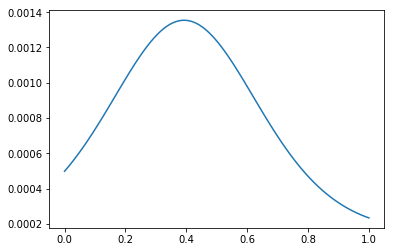

In [69]:
plt.plot(t, b)

Check that we get 1:

In [58]:
1 - ls_qr(A, b)[14]

1.4137685733217609e-07

Bad condition number:

In [60]:
kappa = np.linalg.cond(A); kappa

5.827807196683593e+17

In [181]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [74]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [75]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.set_value(name, 'Time', t)
    df.set_value(name, 'Error', np.abs(1 - coeffs[-1]))

In [76]:
df

,Time,Error
Normal Eqns- Naive,0.001565099,1.357066025
QR Factorization,0.002632104,0.000000116
SVD,0.003503785,0.000000116
Scipy lstsq,0.002763502,0.000000116



The solution for least squares via the normal equations is unstable in general, although stable for problems with small condition numbers.

### Low-rank

In [258]:
m = 100
n = 10
x = np.random.uniform(-10,10,n)
A2 = np.random.uniform(-40,40, [m, int(n/2)])   # removed np.asfortranarray
A = np.hstack([A2, A2])

In [259]:
A.shape, A2.shape

((100, 10), (100, 5))

In [260]:
b = A @ x + np.random.normal(0,1,m)

In [263]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [264]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [265]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.set_value(name, 'Time', t)
    df.set_value(name, 'Error', regr_metrics(b, A @ coeffs)[0])

In [266]:
df

,Time,Error
Normal Eqns- Naive,0.001227640,300.658979382
QR Factorization,0.002315920,0.876019803
SVD,0.001745647,1.584746056
Scipy lstsq,0.002067989,0.804750398


## Comparison

Our results from above:

In [257]:
df

# rows                   100                    1000                     \
# cols                    20       100  1000     20       100      1000   
Normal Eqns- Naive    0.001276 0.003634  NaN 0.000960 0.005172 0.293126   
Normal Eqns- Cholesky 0.001660 0.003958  NaN 0.001665 0.004007 0.093696   
QR Factorization      0.002174 0.006486  NaN 0.004235 0.017773 0.213232   
SVD                   0.003880 0.021737  NaN 0.004672 0.026950 1.280490   
Scipy lstsq           0.004338 0.020198  NaN 0.004320 0.021199 1.083804   

# rows                   10000                    
# cols                    20       100      1000  
Normal Eqns- Naive    0.002226 0.021248 1.164655  
Normal Eqns- Cholesky 0.001928 0.010456 0.399464  
QR Factorization      0.019229 0.116122 2.208129  
SVD                   0.018138 0.130652 3.433003  
Scipy lstsq           0.012200 0.088467 2.134780

From Trefethen (page 84):

Normal equations/Cholesky is fastest when it works.  Cholesky can only be used on symmetric, positive definite matrices.  Also, normal equations/Cholesky is unstable for matrices with high condition numbers or with low-rank.

Linear regression via QR has been recommended by numerical analysts as the standard method for years.  It is natural, elegant, and good for "daily use".